In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from seaborn import countplot, kdeplot
from tqdm import tqdm
from seaborn import heatmap
import scipy.stats as scs

KNN models, specifically KNN classifiers, are exellent at predicting on balanced datasets. However, while I was trying to predict the length of stay from a dataset containing patient data, I found that my model's were performing poorly.

In [ ]:
# training dataframe from synthetic dataset
df_train = pd.read_csv('train_data.csv')


In [6]:
df_train.head(1)

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10


<Axes: xlabel='Stay', ylabel='count'>

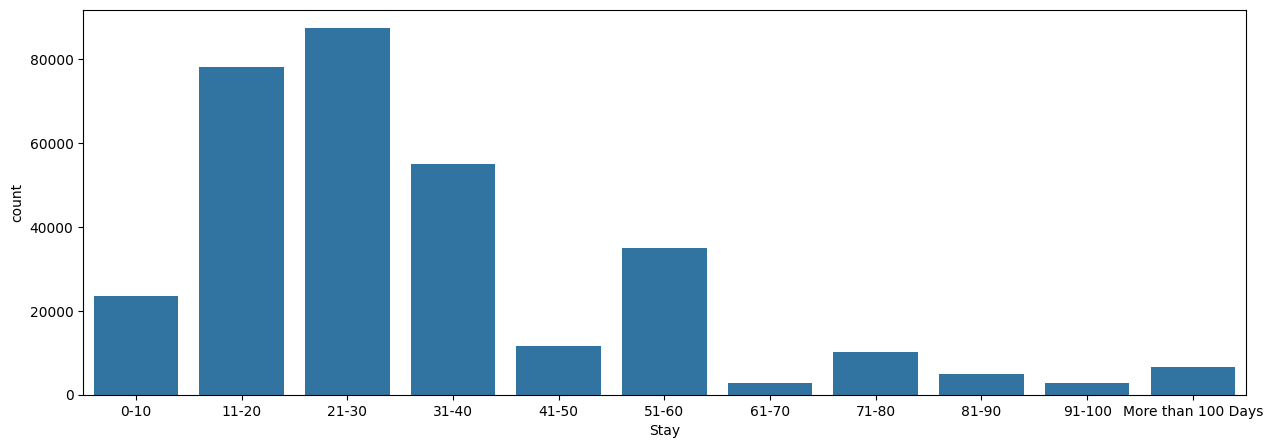

In [11]:
fig, ax = plt.subplots(figsize=(15,5))
countplot(data=df_train, x=df_train["Stay"].sort_values(), ax=ax)

Taking a look at the training data, and specifically when looking at the target "Stay", we can see that Stay suffers from class imbalance, which will be a problem when using a classic knn model. Let's explore why by training and testing a knn model.

I have done EDA in much greater detail in explore.ipynb, where I discuss why I have dropped and trainsformed predictors in the way I have. This is not mandatory reading to continue through this workbook.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

df_test = pd.read_csv("test_data.csv")

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit